In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
## this is a study that tracks the 5dayMA against the 200dayMA
## it simply looks at stats addressing the duration the 5dayMA stays ABOVE or BELOW the 200dayMA
## the bar charts shows:
##     1. the historical cycles of above and below
##     2. the historical distribution of durations above and below


In [2]:
import pandas
from indicators import MA

def calc_ma_stats(df):
    rf = df.copy()
    rf['ma5'] = None
    rf['ma200'] = None
    rf['Count'] = None
    ma5 = MA(5)
    ma200 = MA(200)
    above = None
    overs = []
    unders = []
    composite = []
    count = 0
    mk_dt = None
    for i in range(df.shape[0]):
        index = df.index[i]
        close_price = df.iloc[i]['Close']
        dt = df.iloc[i]['Date']
        if not mk_dt: mk_dt = dt
        m = ma200.push(close_price)
        v = ma5.push(close_price)
        rf.at[index, 'ma200'] = m
        rf.at[index, 'ma5'] = v
        if v is not None and m is not None:
            # ma5 is ABOVE ma200
            if v >= m:
                # continue to count current days ABOVE ma200
                if above is None or above is True:
                    count += 1
                # ma5 was previously BELOW ma200
                elif above == False:
                    unders.append(count)
                    composite.append((-count, mk_dt))
                    count = 1
                    mk_dt = dt
                above = True
            # ma5 is BELOW ma200
            else:
                # continue to count current days BELOW ma200
                if above is None or above is False:
                    count += 1
                elif above == True:
                    overs.append(count)
                    composite.append((count, mk_dt))
                    count = 1
                    mk_dt = dt
                above = False
            
            # martk running count above or below
            h = count
            if above == False: h = -count
            rf.at[index, "Count"] = h
    
    # tack on the current running count
    if above:
        overs.append(count)
        composite.append((count, mk_dt))
    else:
        unders.append(count)
        composite.append((-count, mk_dt))
                    
    return overs, unders, composite, rf

In [3]:
### update symbol here

SYMBOL = "^GSPC"
HISTO_WIDTH = 50

In [4]:
df = pandas.read_csv(f'/home/jcarter/sandbox/trading/data/{SYMBOL}.csv')
overs, unders, composite, gg = calc_ma_stats(df)
gg.set_index('Date',inplace=True)

compdts = [ x[1] for x in composite]
compvals = [ x[0] for x in composite]

def _choose_color(val):
    if val < 0:
        return 'red'
    return 'green'
    
compcolors = [ _choose_color(x) for x in compvals]

print(gg[['ma5', 'ma200', 'Count']].tail(20))

                ma5    ma200 Count
Date                              
2022-10-26  3781.12  4121.93  -138
2022-10-27  3809.42   4117.4  -139
2022-10-28  3839.08  4113.27  -140
2022-10-31  3854.01  4109.34  -141
2022-11-01  3853.41   4105.3  -142
2022-11-02  3839.23  4101.22  -143
2022-11-03  3821.74  4097.15  -144
2022-11-04  3795.64  4093.59  -145
2022-11-07  3782.61  4090.64  -146
2022-11-08  3777.01  4087.73  -147
2022-11-09  3774.78  4084.69  -148
2022-11-10  3822.08  4082.72  -149
2022-11-11  3866.56  4081.05  -150
2022-11-14  3896.65  4078.68  -151
2022-11-15  3929.37  4076.06  -152
2022-11-16  3971.41  4073.12  -153
2022-11-17  3969.45  4069.91  -154
2022-11-18  3963.93  4067.34  -155
2022-11-21  3962.47  4064.59  -156
2022-11-22  3964.84  4062.19  -157


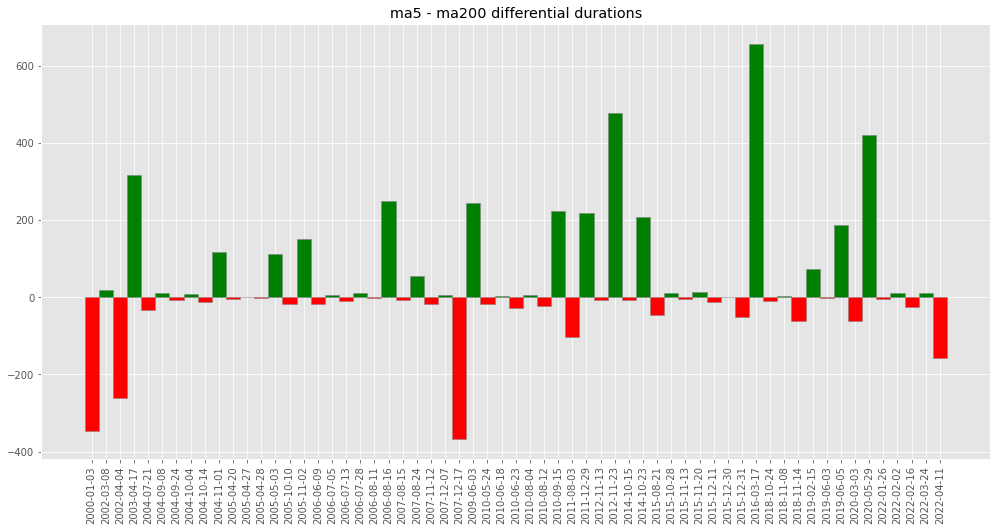

In [5]:

plt.style.use('ggplot')

x_pos = list(range(len(compvals)))

plt.figure(figsize=(17,8))
plt.bar(x_pos, compvals, color=compcolors, edgecolor='gray', width=1.0)
#plt.xlabel("Energy Source")
#plt.ylabel("Energy Output (GJ)")
plt.title("ma5 - ma200 differential durations")

plt.xticks(x_pos, compdts, rotation=90)

plt.show()

ABOVE 200-day-MA
[18, 316, 12, 8, 117, 1, 111, 150, 6, 10, 250, 55, 6, 245, 3, 6, 223, 219, 476, 208, 12, 14, 1, 657, 4, 73, 187, 419, 10, 12]


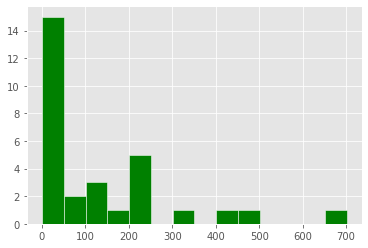

In [6]:
print("ABOVE 200-day-MA")
print(overs)

bins = np.arange(min(overs), max(overs) + HISTO_WIDTH, HISTO_WIDTH)

matplotlib.pyplot.hist(overs, color='green',edgecolor='white', bins=bins)
matplotlib.pyplot.grid(True)


BELOW 200-day-MA
[346, 262, 34, 6, 12, 5, 3, 17, 17, 11, 3, 7, 18, 367, 18, 29, 23, 103, 7, 6, 47, 5, 12, 52, 11, 62, 2, 61, 5, 25, 157]


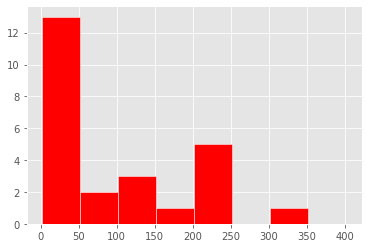

In [7]:
print("BELOW 200-day-MA")
print(unders)

bins = np.arange(min(unders), max(unders) + HISTO_WIDTH, HISTO_WIDTH)

matplotlib.pyplot.hist(overs, color='red',edgecolor='white', bins=bins)
matplotlib.pyplot.grid(True)

In [8]:
sum(overs)/(sum(overs) + sum(unders))

0.6884214311398777

In [9]:
import statistics
print(f'Stdev= {statistics.pstdev(unders)}')
print(f'Mean= {statistics.mean(unders)}')

Stdev= 94.88171068152302
Mean= 55.903225806451616


In [10]:
# 2 Stdev = 54 + 2*90 = approx 230, half life = 115, 
# therefore present conditions are going to start to shift, or we are in it a downtrend for 
# quite sometime going forward.